<a href="https://colab.research.google.com/github/oganiler/google_colab/blob/main/Transfer_Learning_(VGG16)_WITHOUT_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2026-02-24 11:52:48--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dn721600.ca.archive.org/0/items/food-5-k/Food-5K.zip [following]
--2026-02-24 11:52:49--  https://dn721600.ca.archive.org/0/items/food-5-k/Food-5K.zip
Resolving dn721600.ca.archive.org (dn721600.ca.archive.org)... 204.62.247.19
Connecting to dn721600.ca.archive.org (dn721600.ca.archive.org)|204.62.247.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  39.5MB/s    in 10s     

2026-02-24 11:53:00 (40.7 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [4]:
!unzip -qq -o Food-5K.zip


In [8]:
!mkdir data



In [9]:
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [10]:
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [11]:
train_path = 'data/train'
valid_path = 'data/test'
IMAGE_SIZE = [224, 224]

In [12]:
batch_size = 128
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  valid_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [13]:
# check the class names
class_names = train_ds.class_names
K = len(class_names)
print(class_names)

['food', 'nonfood']


In [14]:
# apply preprocess_input once so that we do not have to put into loop
def preprocess(image, label):
  return preprocess_input(image), label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [15]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [18]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# map the vgg output data into feature vectors to built-in logistic regression
x = Flatten()(ptm.output)

In [20]:
# create a model object for logistic regression inluding vgg body
model = Model(inputs=ptm.input, outputs=x)

In [21]:
# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Prepare the outputs from the vgg body for logistic regression
X_train = model.predict(train_ds)
X_valid = model.predict(val_ds)

#and match with the outputs
# NOTE: this won't work if you shuffled the train set!
# (it shuffles everytime you iterate through it)
Y_train = np.concatenate([y for x, y in train_ds])
Y_valid = np.concatenate([y for x, y in val_ds])

D = X_train.shape[1]

X_train.shape, Y_train.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 1610s 66s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 517s 64s/step


((3000, 25088), (3000,))

In [23]:
#we need the normalize the data since we will be using logistic regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [26]:
# Try the built-in logistic regression

from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.986


In [27]:
# Let'S do logistic regression in "Tensorflow"

In [28]:
#logistic regression in "Tensorflow" Model
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [29]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [30]:
# Can try both normalized and unnormalized data
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8497 - loss: 2.1039 - val_accuracy: 0.9800 - val_loss: 0.3439
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9934 - loss: 0.0796 - val_accuracy: 0.9800 - val_loss: 0.2940
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9969 - loss: 0.0164 - val_accuracy: 0.9760 - val_loss: 0.3682
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.9800 - val_loss: 0.3208
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9991 - loss: 0.0080 - val_accuracy: 0.9830 - val_loss: 0.3065
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 1.4928e-06 - val_accuracy: 0.9820 - val_loss: 0.3169
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 2.6832e-06 - val_accuracy: 0.9820 - val_loss: 0.3173
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.2741e-06 - val_accuracy

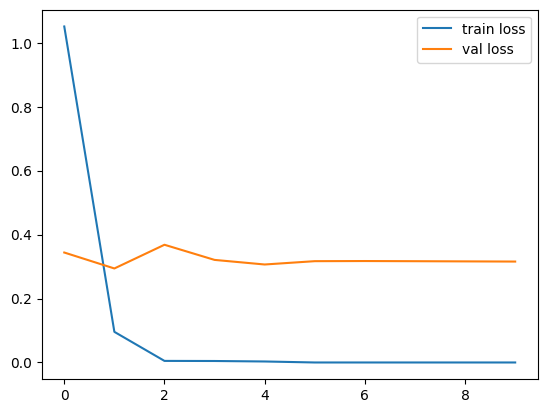

In [31]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

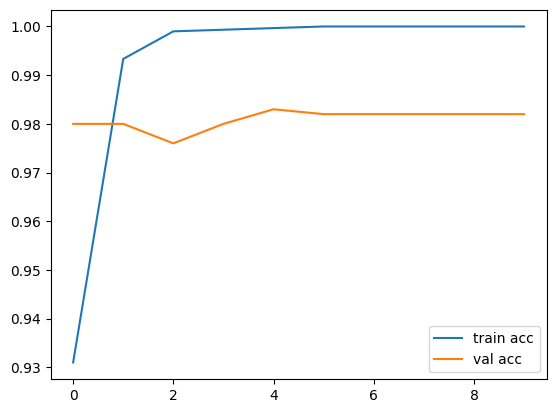

In [32]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()